In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statistics

from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder,StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns",None)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [7]:
df_new = pd.read_csv("data/12300_dong.csv")


## Tiền xử lý DL

### Loại bỏ những gì trị dư thừa

#### Lọc dữ liệu dựa trên phạm vi của vĩ độ và kinh độ

In [8]:
# Lọc dữ liệu dựa trên phạm vi của vĩ độ và kinh độ
df_new = df_new[
    (df_new["Restaurant_latitude"] >= 7.00) & 
    (df_new["Restaurant_latitude"] <= 37.00) & 
    (df_new["Delivery_location_latitude"] >= 7.00) & 
    (df_new["Delivery_location_latitude"] <= 37.00) & 
    (df_new["Restaurant_longitude"] >= 68) & 
    (df_new["Restaurant_longitude"] <= 98) & 
    (df_new["Delivery_location_longitude"] >= 68) & 
    (df_new["Delivery_location_longitude"] <= 98)
].reset_index(drop=True).copy()

df_new


,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,8:30:00,8:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
2,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,5/4/2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
3,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30
4,0x9bb4,HYDRES09DEL03,22,4.8,17.431668,78.408321,17.461668,78.438321,11/3/2022,21:20:00,21:30:00,conditions Cloudy,Jam,0,Buffet,motorcycle,1,No,Urban,(min) 26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11158,0xb954,HYDRES12DEL01,34,4.7,17.429585,78.392621,17.499585,78.462621,14-03-2022,17:45:00,17:55:00,conditions Windy,Medium,1,Snack,scooter,1,No,Metropolitian,(min) 22
11159,0xd538,GOARES15DEL01,23,5,15.513150,73.783460,15.623150,73.893460,16-02-2022,18:50:00,19:00:00,conditions Windy,Medium,2,Drinks,electric_scooter,1,No,Metropolitian,(min) 21
11160,0x940,SURRES02DEL02,50,6,21.186608,72.794136,21.206608,72.814136,1/3/2022,NaN,11:25:00,conditions NaN,NaN,3,Meal,scooter,1,No,Urban,(min) 22
11161,0xd19f,AURGRES09DEL03,27,4.8,19.874103,75.368419,19.934103,75.428419,15-02-2022,20:15:00,20:25:00,conditions Sunny,Jam,1,Snack,scooter,1,No,Urban,(min) 18


#### Tính khoảng cách đường bộ từ các cặp tọa độ bằng thư viện OSRM. Sau đó thêm cột distance vào data. Do thời gian chạy lâu nên em đóng phần code này ở comment ạ

In [9]:
import requests
import pandas as pd

def calculate_distance_osrm(origin_lat, origin_lon, dest_lat, dest_lon):
    # Định dạng URL của OSRM API
    origin = f"{origin_lon},{origin_lat}"
    destination = f"{dest_lon},{dest_lat}"
    url = f"http://router.project-osrm.org/route/v1/driving/{origin};{destination}?overview=false"
    
    # Gửi yêu cầu đến OSRM API
    response = requests.get(url)
    
    # Phân tích kết quả JSON
    data = response.json()
    
    # Kiểm tra xem kết quả có chứa khóa 'routes' hay không
    if 'routes' in data and len(data['routes']) > 0:
        # Trích xuất khoảng cách từ kết quả
        distance = data['routes'][0]['distance']  # Khoảng cách tính bằng mét
        # Chuyển đổi khoảng cách từ mét sang kilômét
        distance_in_km = distance / 1000
        return distance_in_km
    else:
        # Trường hợp không tìm thấy tuyến đường, trả về giá trị mặc định là -1
        return -1  

#df = pd.read_csv('train.csv')

# Tạo một cột mới để lưu khoảng cách
df_train['distance_km'] = 0.0

# Sử dụng vòng for để tính khoảng cách cho từng hàng
for index, row in df_train.iterrows():
    restaurant_latitude = row['Restaurant_latitude']
    restaurant_longitude = row['Restaurant_longitude']
    delivery_latitude = row['Delivery_location_latitude']
    delivery_longitude = row['Delivery_location_longitude']
    
    # Tính khoảng cách và gán vào cột mới
    distance = calculate_distance_osrm(restaurant_latitude, restaurant_longitude, delivery_latitude, delivery_longitude)
    df_train.at[index, 'distance_km'] = distance

# Lưu DataFrame đã cập nhật vào file CSV gốc
df_train.to_csv('train_with_distances_123000_dong.csv', index=False)
df_train.head(5)


#### Ta được data mới

In [10]:
#data mới
df_new=pd.read_csv('data/train_with_distances_12300_dong.csv')
df_new

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),distance_km
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24,5.1959
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33,28.9722
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,8:30:00,8:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26,5.1475
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,5/4/2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21,13.1790
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30,10.5799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11158,0x1204,JAPRES06DEL03,26,4.7,26.911927,75.797282,27.001927,75.887282,12/3/2022,23:50:00,0:00:00,conditions Fog,Low,0,Snack,motorcycle,1,No,Urban,(min) 20,19.5478
11159,0xb954,HYDRES12DEL01,34,4.7,17.429585,78.392621,17.499585,78.462621,14-03-2022,17:45:00,17:55:00,conditions Windy,Medium,1,Snack,scooter,1,No,Metropolitian,(min) 22,21.9109
11160,0xd538,GOARES15DEL01,23,5,15.513150,73.783460,15.623150,73.893460,16-02-2022,18:50:00,19:00:00,conditions Windy,Medium,2,Drinks,electric_scooter,1,No,Metropolitian,(min) 21,24.8817
11161,0x940,SURRES02DEL02,50,6,21.186608,72.794136,21.206608,72.814136,1/3/2022,NaN,11:25:00,conditions NaN,NaN,3,Meal,scooter,1,No,Urban,(min) 22,3.4398


In [11]:
df_new.drop(1, inplace=True)

In [12]:
def convert_nan(df):
    df.replace('NaN', float(np.nan), regex=True,inplace=True)

convert_nan(df_new)

#### Chỉnh đúng định dạng

- Xóa cột không dùng đến

In [13]:
df_new = df_new.drop(columns=['ID', 'Delivery_person_ID'])

In [14]:
df_new.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),distance_km
0,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24,5.1959
2,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,8:30:00,8:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26,5.1475
3,38,4.7,11.003669,76.976494,11.053669,77.026494,5/4/2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21,13.1790
4,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30,10.5799
5,22,4.8,17.431668,78.408321,17.461668,78.438321,11/3/2022,21:20:00,21:30:00,conditions Cloudy,Jam,0,Buffet,motorcycle,1,No,Urban,(min) 26,10.0741


- Chuyển đổi đúng kiểu DL

In [15]:
def update_datatype(df):
    df['Delivery_person_Ratings'] = df['Delivery_person_Ratings'].astype('float64')
    df['Delivery_person_Age'] = df['Delivery_person_Age'].astype('float64')
    df['multiple_deliveries'] = df['multiple_deliveries'].astype('float64')
    #Nhất quán date về cùng một định dạng
    def parse_date(date_str):
        for fmt in ("%d-%m-%Y", "%m/%d/%Y"):
            try:
                return pd.to_datetime(date_str, format=fmt)
            except ValueError:
                continue
        return pd.to_datetime(date_str)  

    df['Order_Date'] = df['Order_Date'].apply(parse_date)

update_datatype(df_new)


- Loại DL dư thừa ở các cột

In [16]:

def extract_column_value(df):
    #Chỉnh sửa cột Time và chuyển dữ liệu thành loại int
    df['Time_taken(min)'] = df['Time_taken(min)'].apply(lambda x: int(x.split(' ')[1].strip()))
    # chia thành 2 phần = khoảng trắng, sau đó chỉ lấy phần thứ 2 (số phút), rồi chuyển số phút -> int
    df['Weather_conditions'] = df['Weather_conditions'].apply(lambda x: x.split(' ')[1].strip() if isinstance(x, str) else x)

extract_column_value(df_new)
df_new.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),distance_km
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24,5.1959
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,8:30:00,8:45:00,Sandstorms,Low,0,Drinks,motorcycle,1.0,No,Urban,26,5.1475
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-05-04,18:00:00,18:10:00,Sunny,Medium,0,Buffet,motorcycle,1.0,No,Metropolitian,21,13.1790
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,High,1,Snack,scooter,1.0,No,Metropolitian,30,10.5799
5,22.0,4.8,17.431668,78.408321,17.461668,78.438321,2022-11-03,21:20:00,21:30:00,Cloudy,Jam,0,Buffet,motorcycle,1.0,No,Urban,26,10.0741


### Trích xuất DL Date sang ngày, tháng, năm...

In [17]:
#Chuyển date sang DL nhỏ
def extract_date_features(data):
    data["day"] = data.Order_Date.dt.day
    data["month"] = data.Order_Date.dt.month
    data["quarter"] = data.Order_Date.dt.quarter
    data["year"] = data.Order_Date.dt.year
    data['day_of_week'] = data.Order_Date.dt.day_of_week.astype(int)
    data["is_month_start"] = data.Order_Date.dt.is_month_start.astype(int)
    data["is_month_end"] = data.Order_Date.dt.is_month_end.astype(int)
    data["is_quarter_start"] = data.Order_Date.dt.is_quarter_start.astype(int)
    data["is_quarter_end"] = data.Order_Date.dt.is_quarter_end.astype(int)
    data["is_year_start"] = data.Order_Date.dt.is_year_start.astype(int)
    data["is_year_end"] = data.Order_Date.dt.is_year_end.astype(int)
    #Ngày thứ 5 và thứ 6 trong tuần là thứ sáu và thứ bảy
    data['is_weekend'] = np.where(data['day_of_week'].isin([5,6]),1,0)

extract_date_features(df_new)
df_new

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),distance_km,day,month,quarter,year,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24,5.1959,19,3,1,2022,5,0,0,0,0,0,0,1
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,8:30:00,8:45:00,Sandstorms,Low,0,Drinks,motorcycle,1.0,No,Urban,26,5.1475,19,3,1,2022,5,0,0,0,0,0,0,1
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-05-04,18:00:00,18:10:00,Sunny,Medium,0,Buffet,motorcycle,1.0,No,Metropolitian,21,13.1790,4,5,2,2022,2,0,0,0,0,0,0,0
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,High,1,Snack,scooter,1.0,No,Metropolitian,30,10.5799,26,3,1,2022,5,0,0,0,0,0,0,1
5,22.0,4.8,17.431668,78.408321,17.461668,78.438321,2022-11-03,21:20:00,21:30:00,Cloudy,Jam,0,Buffet,motorcycle,1.0,No,Urban,26,10.0741,3,11,4,2022,3,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11158,26.0,4.7,26.911927,75.797282,27.001927,75.887282,2022-12-03,23:50:00,0:00:00,Fog,Low,0,Snack,motorcycle,1.0,No,Urban,20,19.5478,3,12,4,2022,5,0,0,0,0,0,0,1
11159,34.0,4.7,17.429585,78.392621,17.499585,78.462621,2022-03-14,17:45:00,17:55:00,Windy,Medium,1,Snack,scooter,1.0,No,Metropolitian,22,21.9109,14,3,1,2022,0,0,0,0,0,0,0,0
11160,23.0,5.0,15.513150,73.783460,15.623150,73.893460,2022-02-16,18:50:00,19:00:00,Windy,Medium,2,Drinks,electric_scooter,1.0,No,Metropolitian,21,24.8817,16,2,1,2022,2,0,0,0,0,0,0,0
11161,50.0,6.0,21.186608,72.794136,21.206608,72.814136,2022-01-03,NaN,11:25:00,NaN,NaN,3,Meal,scooter,1.0,No,Urban,22,3.4398,3,1,1,2022,0,0,0,0,0,0,0,0


### Số lượng giá trị thiếu

In [18]:
df_new.isnull().sum().sort_values(ascending=False)

Delivery_person_Ratings        385
Delivery_person_Age            376
Time_Orderd                    346
City                           304
multiple_deliveries            242
Weather_conditions             116
Road_traffic_density           112
Festival                        46
Time_Order_picked                0
month                            0
is_year_end                      0
is_year_start                    0
is_quarter_end                   0
is_quarter_start                 0
is_month_end                     0
is_month_start                   0
day_of_week                      0
year                             0
quarter                          0
day                              0
Order_Date                       0
distance_km                      0
Time_taken(min)                  0
Restaurant_latitude              0
Restaurant_longitude             0
Delivery_location_latitude       0
Type_of_vehicle                  0
Type_of_order                    0
Vehicle_condition   

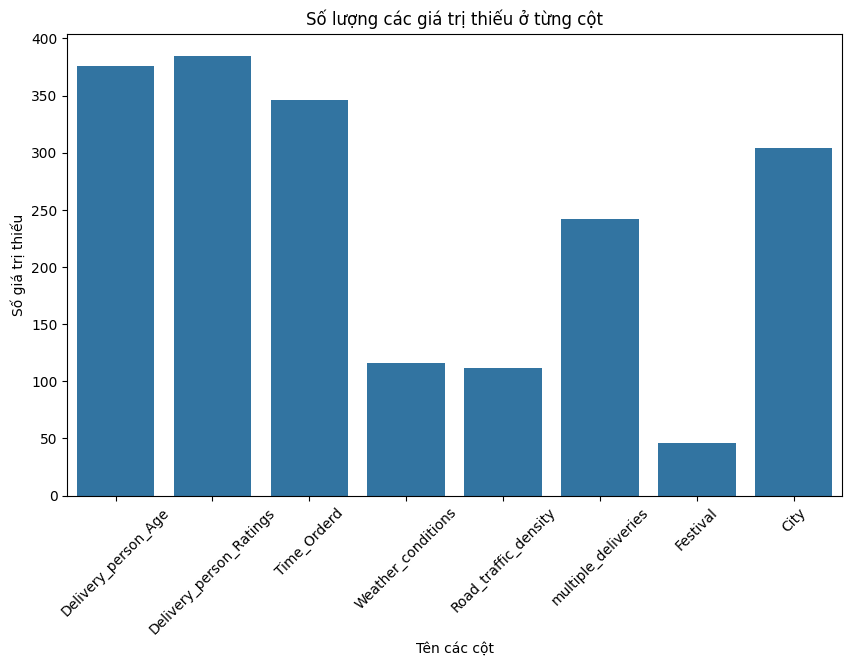

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

missing_values = df_new.isnull().sum()

missing_values = missing_values[missing_values > 0]

plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values.index, y=missing_values.values)
plt.xticks(rotation=45)
plt.xlabel('Tên các cột')
plt.ylabel('Số giá trị thiếu')
plt.title('Số lượng các giá trị thiếu ở từng cột')
plt.show()


In [20]:
# import xgboost as xgb

# # Sử dụng từ điển để ánh xạ tên cột với các nhãn
# feature_importances = model.get_booster().get_score(importance_type='weight')
# sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# # Tạo biểu đồ tầm quan trọng của đặc trưng
# plt.figure(figsize=(10, 8))
# plt.barh([feature_names[int(key[1:])] for key, _ in sorted_importances], [value for _, value in sorted_importances])
# plt.xlabel('Tầm quan trọng của đặc trưng')
# plt.ylabel('Đặc trưng')
# plt.gca().invert_yaxis()
# plt.show()



### Heatmap trước khi xử lý

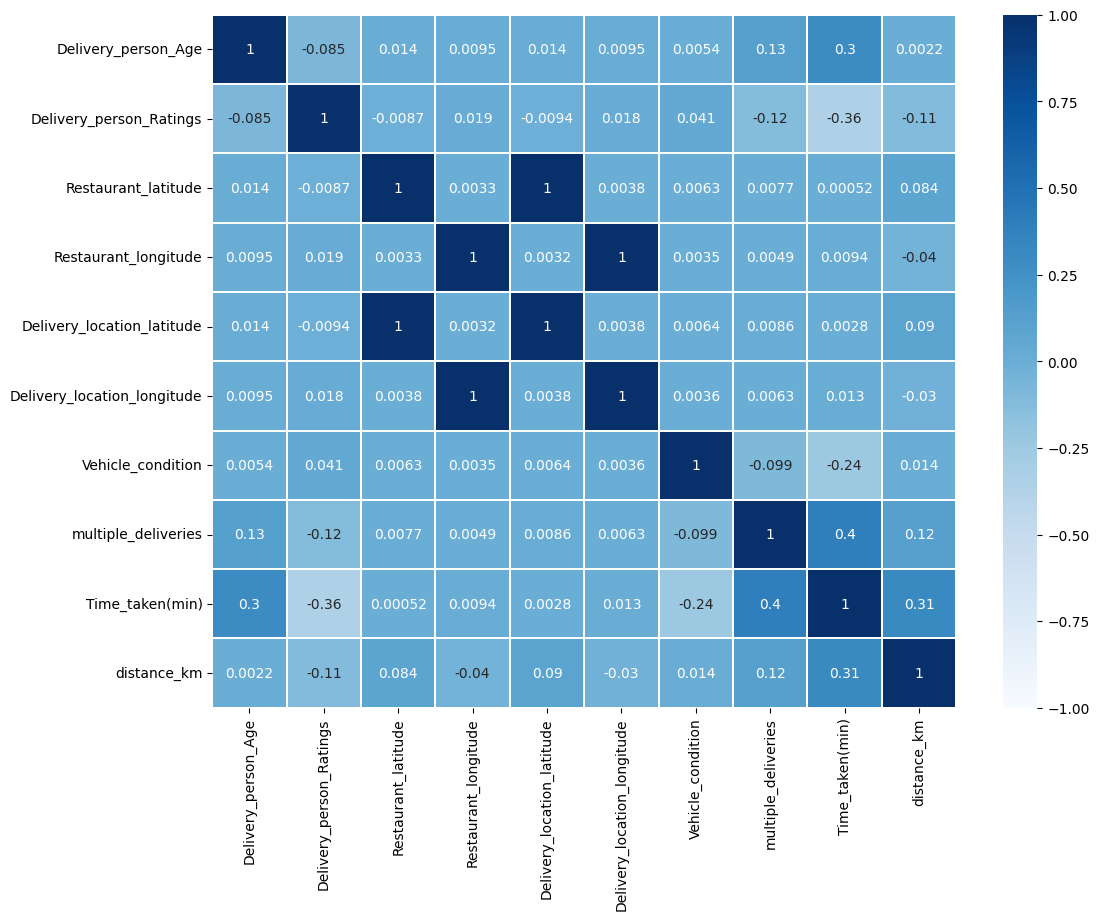

In [21]:
plt.figure(figsize=(12,9))
sns.heatmap(df_new.select_dtypes(include=['float64', 'int64']).corr(), annot=True, linewidth=0.1, cmap="Blues", vmin=-1, vmax=1)

plt.show()

### Age

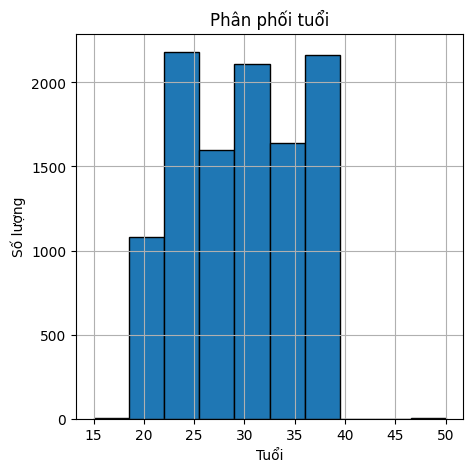

In [22]:
# Vẽ biểu đồ histogram
plt.figure(figsize=(5, 5))
plt.hist(df_new['Delivery_person_Age'], bins=10, edgecolor='black')
plt.title('Phân phối tuổi')
plt.xlabel('Tuổi')
plt.ylabel('Số lượng')
plt.grid(True)
plt.show()

In [23]:
imputer  = SimpleImputer(missing_values=np.nan, strategy="mean")
df_new['Delivery_person_Age'] = imputer.fit_transform(df_new[['Delivery_person_Age']])


### Weather Conditions

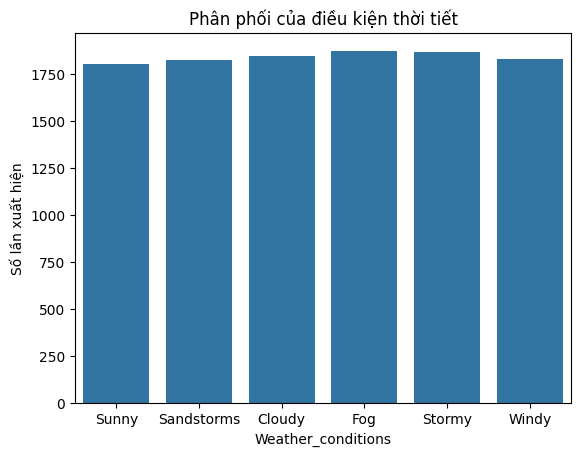

In [24]:
# Vẽ biểu đồ countplot cho cột Weather_conditions
sns.countplot(x='Weather_conditions', data=df_new)

# Thêm tiêu đề và nhãn cho biểu đồ
plt.title('Phân phối của điều kiện thời tiết')
plt.xlabel('Weather_conditions')
plt.ylabel('Số lần xuất hiện')

# Hiển thị biểu đồ
plt.show()

In [25]:
#C1: mode
def handle_null_values(df):
    df['Weather_conditions'].fillna(df['Weather_conditions'].mode()[0], inplace=True)

handle_null_values(df_new)


In [26]:
# #C2: random
# def handle_null_values(df):
   
#     df['Weather_conditions'].fillna(np.random.choice(df['Weather_conditions']), inplace=True)

# handle_null_values(df_new)


### Xử lý DL thiếu cột Time_orderd bằng cách tạo thêm cột
- Order_prepare_time = Time_Order_picked - Time_Orderd
- Sau đó thay các giá trị NULL = mean


In [27]:
def calculate_time_diff(df):
    # Chuyển đổi các cột thời gian thành định dạng datetime
    df['Order_Date'] = pd.to_datetime(df['Order_Date'])
    df['Time_Orderd'] = pd.to_timedelta(df['Time_Orderd'])
    df['Time_Order_picked'] = pd.to_timedelta(df['Time_Order_picked'])
    
    # Tính toán thời gian đặt hàng và thời gian lấy hàng
    df['Time_Order_picked_formatted'] = df['Order_Date'] + np.where(df['Time_Order_picked'] < df['Time_Orderd'], pd.DateOffset(days=1), pd.DateOffset(days=0)) + df['Time_Order_picked']
    df['Time_Ordered_formatted'] = df['Order_Date'] + df['Time_Orderd']
    
    # Chuyển đổi các cột thành kiểu datetime nếu chúng không phải là kiểu datetime
    df['Time_Order_picked_formatted'] = pd.to_datetime(df['Time_Order_picked_formatted'])
    df['Time_Ordered_formatted'] = pd.to_datetime(df['Time_Ordered_formatted'])
    
    # Tính toán thời gian chuẩn bị đơn hàng
    df['order_prepare_time'] = (df['Time_Order_picked_formatted'] - df['Time_Ordered_formatted']).dt.total_seconds() / 60
    
    # # Xử lý giá trị null bằng các giá trị trung bình
    # df['order_prepare_time'].fillna(df['order_prepare_time'].mean(), inplace=True)

    df.drop(['Time_Orderd', 'Time_Order_picked', 'Time_Ordered_formatted', 'Order_Date'], axis=1, inplace=True)

calculate_time_diff(df_new)
df_new.head()


,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),distance_km,day,month,quarter,year,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend,Time_Order_picked_formatted,order_prepare_time
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24,5.1959,19,3,1,2022,5,0,0,0,0,0,0,1,2022-03-19 11:45:00,15.0
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,Sandstorms,Low,0,Drinks,motorcycle,1.0,No,Urban,26,5.1475,19,3,1,2022,5,0,0,0,0,0,0,1,2022-03-19 08:45:00,15.0
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,Sunny,Medium,0,Buffet,motorcycle,1.0,No,Metropolitian,21,13.1790,4,5,2,2022,2,0,0,0,0,0,0,0,2022-05-04 18:10:00,10.0
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,Cloudy,High,1,Snack,scooter,1.0,No,Metropolitian,30,10.5799,26,3,1,2022,5,0,0,0,0,0,0,1,2022-03-26 13:45:00,15.0
5,22.0,4.8,17.431668,78.408321,17.461668,78.438321,Cloudy,Jam,0,Buffet,motorcycle,1.0,No,Urban,26,10.0741,3,11,4,2022,3,0,0,0,0,0,0,0,2022-11-03 21:30:00,10.0


In [28]:
df_new['Time_shipper'] = df_new['Time_taken(min)'] - df_new['order_prepare_time']
df_new = df_new.drop(columns=['Time_taken(min)'])

df_new.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,distance_km,day,month,quarter,year,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend,Time_Order_picked_formatted,order_prepare_time,Time_shipper
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,5.1959,19,3,1,2022,5,0,0,0,0,0,0,1,2022-03-19 11:45:00,15.0,9.0
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,Sandstorms,Low,0,Drinks,motorcycle,1.0,No,Urban,5.1475,19,3,1,2022,5,0,0,0,0,0,0,1,2022-03-19 08:45:00,15.0,11.0
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,Sunny,Medium,0,Buffet,motorcycle,1.0,No,Metropolitian,13.1790,4,5,2,2022,2,0,0,0,0,0,0,0,2022-05-04 18:10:00,10.0,11.0
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,Cloudy,High,1,Snack,scooter,1.0,No,Metropolitian,10.5799,26,3,1,2022,5,0,0,0,0,0,0,1,2022-03-26 13:45:00,15.0,15.0
5,22.0,4.8,17.431668,78.408321,17.461668,78.438321,Cloudy,Jam,0,Buffet,motorcycle,1.0,No,Urban,10.0741,3,11,4,2022,3,0,0,0,0,0,0,0,2022-11-03 21:30:00,10.0,16.0


In [29]:
df_new.isnull().sum().sort_values(ascending=False)

Delivery_person_Ratings        385
Time_shipper                   346
order_prepare_time             346
City                           304
multiple_deliveries            242
Road_traffic_density           112
Festival                        46
is_month_end                     0
is_month_start                   0
is_quarter_end                   0
is_quarter_start                 0
year                             0
is_year_start                    0
is_year_end                      0
is_weekend                       0
Time_Order_picked_formatted      0
day_of_week                      0
Delivery_person_Age              0
quarter                          0
month                            0
distance_km                      0
Type_of_vehicle                  0
Type_of_order                    0
Vehicle_condition                0
Weather_conditions               0
Delivery_location_longitude      0
Delivery_location_latitude       0
Restaurant_longitude             0
Restaurant_latitude 

### Rating

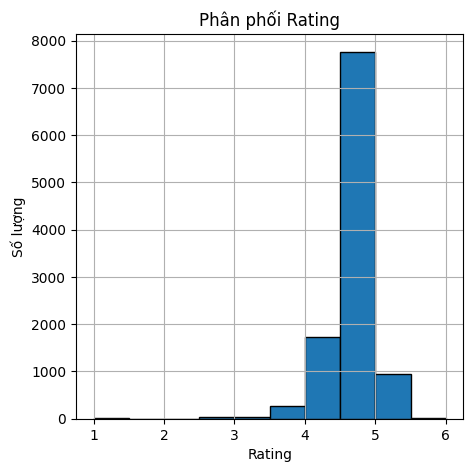

In [30]:
# Vẽ biểu đồ histogram
plt.figure(figsize=(5, 5))
plt.hist(df_new['Delivery_person_Ratings'], bins=10, edgecolor='black')
plt.title('Phân phối Rating')
plt.xlabel('Rating')
plt.ylabel('Số lượng')
plt.grid(True)
plt.show()


In [31]:
df_new = df_new[(df_new['Delivery_person_Ratings'] >= 2) & (df_new['Delivery_person_Ratings'] < 5)]

imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
df_new['Delivery_person_Ratings'] = imputer.fit_transform(df_new[['Delivery_person_Ratings']])


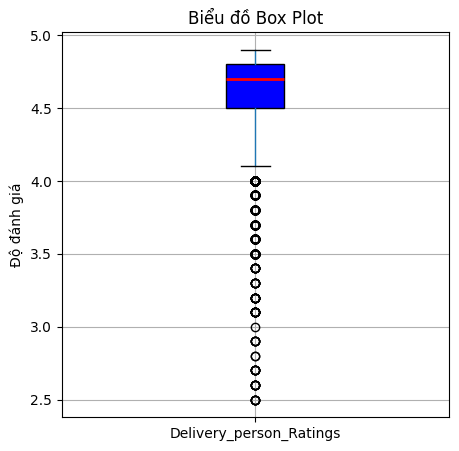

In [32]:
plt.figure(figsize=(5, 5))

boxplot = df_new.boxplot(column=['Delivery_person_Ratings'], patch_artist=True, 
                         boxprops=dict(facecolor='blue'), 
                         medianprops=dict(color='red', linewidth=2)) 

plt.title('Biểu đồ Box Plot')
plt.xlabel('')
plt.ylabel('Độ đánh giá')
plt.show()


In [33]:
def replace_outliers_with_nearest(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[column_name] = np.where(df[column_name] < lower_bound, lower_bound, df[column_name])
    df[column_name] = np.where(df[column_name] > upper_bound, upper_bound, df[column_name])
    return df

# Thay thế giá trị ngoại lai bằng giá trị gần nhất cho cột `Delivery_person_Ratings`
df_new = replace_outliers_with_nearest(df_new, 'Delivery_person_Ratings')


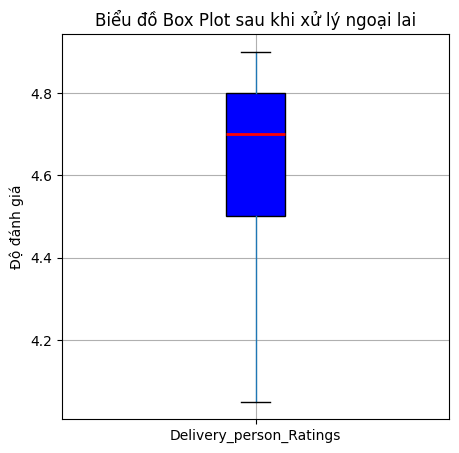

In [34]:

plt.figure(figsize=(5, 5))
boxplot = df_new.boxplot(column=['Delivery_person_Ratings'], patch_artist=True, 
                         boxprops=dict(facecolor='blue'), 
                         medianprops=dict(color='red', linewidth=2))  

plt.title('Biểu đồ Box Plot sau khi xử lý ngoại lai')
plt.xlabel('')
plt.ylabel('Độ đánh giá')
plt.show()


In [35]:
df_new.isnull().sum().sort_values(ascending=False)

City                           262
multiple_deliveries            211
Festival                        36
Delivery_person_Age              0
quarter                          0
order_prepare_time               0
Time_Order_picked_formatted      0
is_weekend                       0
is_year_end                      0
is_year_start                    0
is_quarter_end                   0
is_quarter_start                 0
is_month_end                     0
is_month_start                   0
day_of_week                      0
year                             0
day                              0
month                            0
Delivery_person_Ratings          0
distance_km                      0
Type_of_vehicle                  0
Type_of_order                    0
Vehicle_condition                0
Road_traffic_density             0
Weather_conditions               0
Delivery_location_longitude      0
Delivery_location_latitude       0
Restaurant_longitude             0
Restaurant_latitude 

### multiple_deliveries

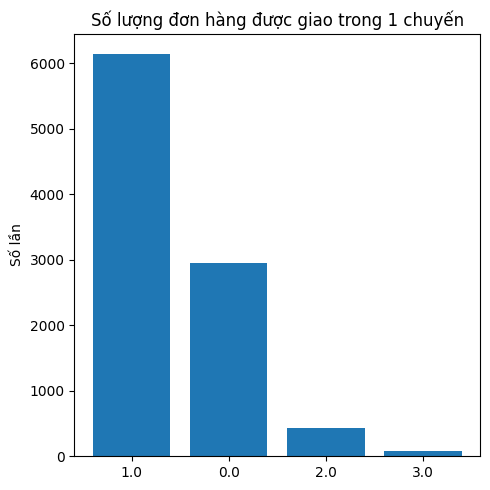

In [36]:

multiple_deliveries = df_new['multiple_deliveries'].value_counts()

fig, ax= plt.subplots( figsize=(5, 5))

ax.bar(multiple_deliveries.index.astype(str), multiple_deliveries.values)
ax.set_title('Số lượng đơn hàng được giao trong 1 chuyến')
ax.set_ylabel('Số lần')
plt.tight_layout()
plt.show()


In [37]:
df_new['multiple_deliveries'].fillna(df_new['multiple_deliveries'].mode()[0], inplace=True)


### City

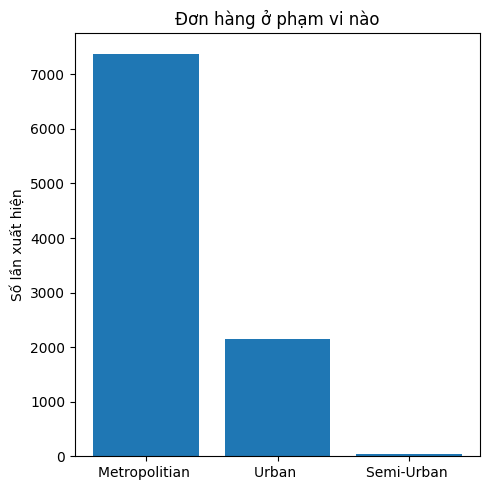

In [38]:

City_count = df_new['City'].value_counts()
fig, (ax) = plt.subplots(figsize=(5, 5))

ax.bar(City_count.index.astype(str), City_count.values)
ax.set_title('Đơn hàng ở phạm vi nào')
ax.set_ylabel('Số lần xuất hiện')

plt.tight_layout()
plt.show()


In [39]:
df_new['City'].fillna(df_new['City'].mode()[0], inplace=True)

### Festival

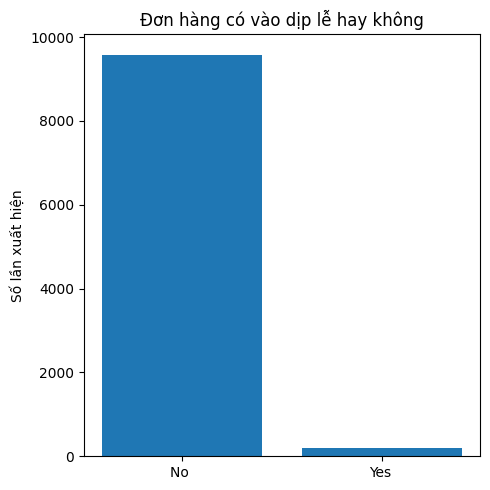

In [40]:
festival_count = df_new['Festival'].value_counts()
fig, (ax) = plt.subplots( figsize=(5,5))

ax.bar(festival_count.index.astype(str), festival_count.values)
ax.set_title('Đơn hàng có vào dịp lễ hay không')
ax.set_ylabel('Số lần xuất hiện')

plt.tight_layout()
plt.show()


In [41]:
df_new['Festival'].fillna('No', inplace=True)


In [42]:
df_new.isnull().sum().sort_values(ascending=False)

Delivery_person_Age            0
Delivery_person_Ratings        0
order_prepare_time             0
Time_Order_picked_formatted    0
is_weekend                     0
is_year_end                    0
is_year_start                  0
is_quarter_end                 0
is_quarter_start               0
is_month_end                   0
is_month_start                 0
day_of_week                    0
year                           0
quarter                        0
month                          0
day                            0
distance_km                    0
City                           0
Festival                       0
multiple_deliveries            0
Type_of_vehicle                0
Type_of_order                  0
Vehicle_condition              0
Road_traffic_density           0
Weather_conditions             0
Delivery_location_longitude    0
Delivery_location_latitude     0
Restaurant_longitude           0
Restaurant_latitude            0
Time_shipper                   0
dtype: int

In [43]:
df_new.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,distance_km,day,month,quarter,year,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend,Time_Order_picked_formatted,order_prepare_time,Time_shipper
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,5.1959,19,3,1,2022,5,0,0,0,0,0,0,1,2022-03-19 11:45:00,15.0,9.0
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,Sandstorms,Low,0,Drinks,motorcycle,1.0,No,Urban,5.1475,19,3,1,2022,5,0,0,0,0,0,0,1,2022-03-19 08:45:00,15.0,11.0
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,Sunny,Medium,0,Buffet,motorcycle,1.0,No,Metropolitian,13.1790,4,5,2,2022,2,0,0,0,0,0,0,0,2022-05-04 18:10:00,10.0,11.0
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,Cloudy,High,1,Snack,scooter,1.0,No,Metropolitian,10.5799,26,3,1,2022,5,0,0,0,0,0,0,1,2022-03-26 13:45:00,15.0,15.0
5,22.0,4.8,17.431668,78.408321,17.461668,78.438321,Cloudy,Jam,0,Buffet,motorcycle,1.0,No,Urban,10.0741,3,11,4,2022,3,0,0,0,0,0,0,0,2022-11-03 21:30:00,10.0,16.0


### Sự tương quan giữa giờ lấy hàng và mật độ giao thông

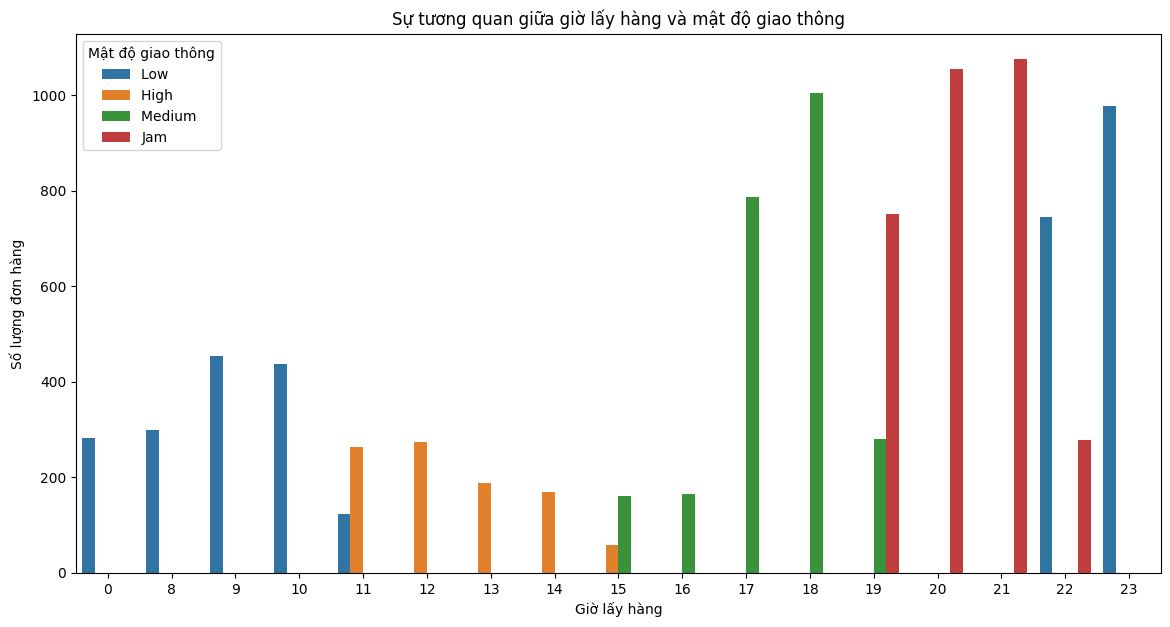

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Chuyển đổi Time_Order_picked_formatted sang giờ trong ngày để dễ vẽ biểu đồ
df_new['Hour_Picked'] = df_new['Time_Order_picked_formatted'].dt.hour

# Vẽ biểu đồ phân phối mật độ giao thông theo giờ trong ngày
plt.figure(figsize=(14, 7))
sns.countplot(x='Hour_Picked', hue='Road_traffic_density', data=df_new)
plt.title('Sự tương quan giữa giờ lấy hàng và mật độ giao thông')
plt.xlabel('Giờ lấy hàng')
plt.ylabel('Số lượng đơn hàng')
plt.legend(title='Mật độ giao thông')
plt.show()


### Type_of_vehicle và Type_of_order

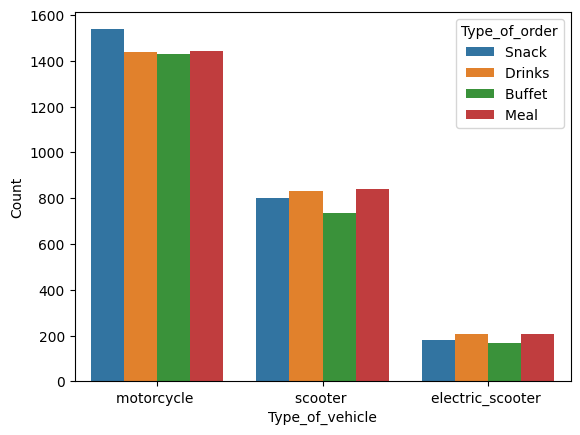

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Vẽ grouped bar chart
sns.countplot(x='Type_of_vehicle', hue='Type_of_order', data=df_new)
plt.title('')
plt.xlabel('Type_of_vehicle')
plt.ylabel('Count')
plt.legend(title='Type_of_order')
plt.show()


### Distance

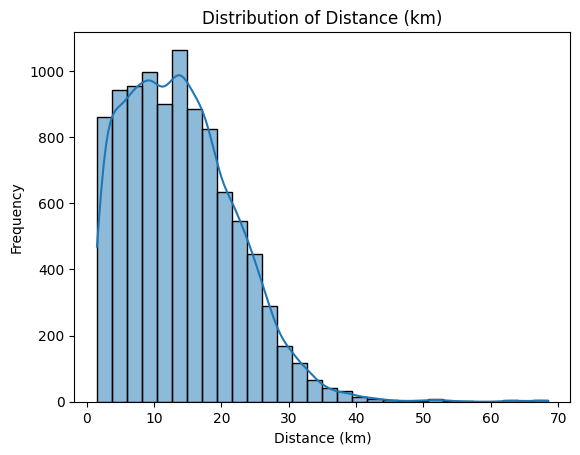

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_new['distance_km'], bins=30, kde=True)
plt.title('Distribution of Distance (km)')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.show()


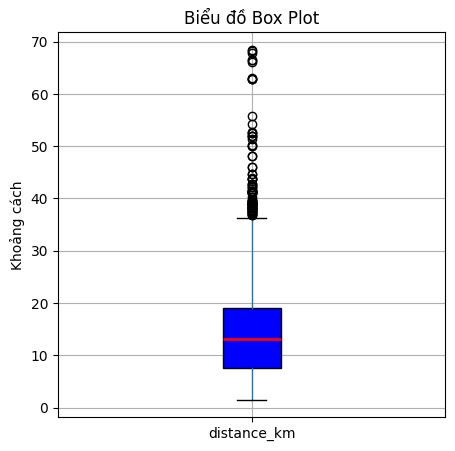

In [47]:
plt.figure(figsize=(5, 5))

boxplot = df_new.boxplot(column=['distance_km'], patch_artist=True, 
                         boxprops=dict(facecolor='blue'), 
                         medianprops=dict(color='red', linewidth=2)) 

plt.title('Biểu đồ Box Plot')
plt.xlabel('')
plt.ylabel('Khoảng cách')
plt.show()


### Biểu đồ phân tán giữa khoảng cách, thời gian ship và giao thông

<Axes: xlabel='distance_km', ylabel='Time_shipper'>

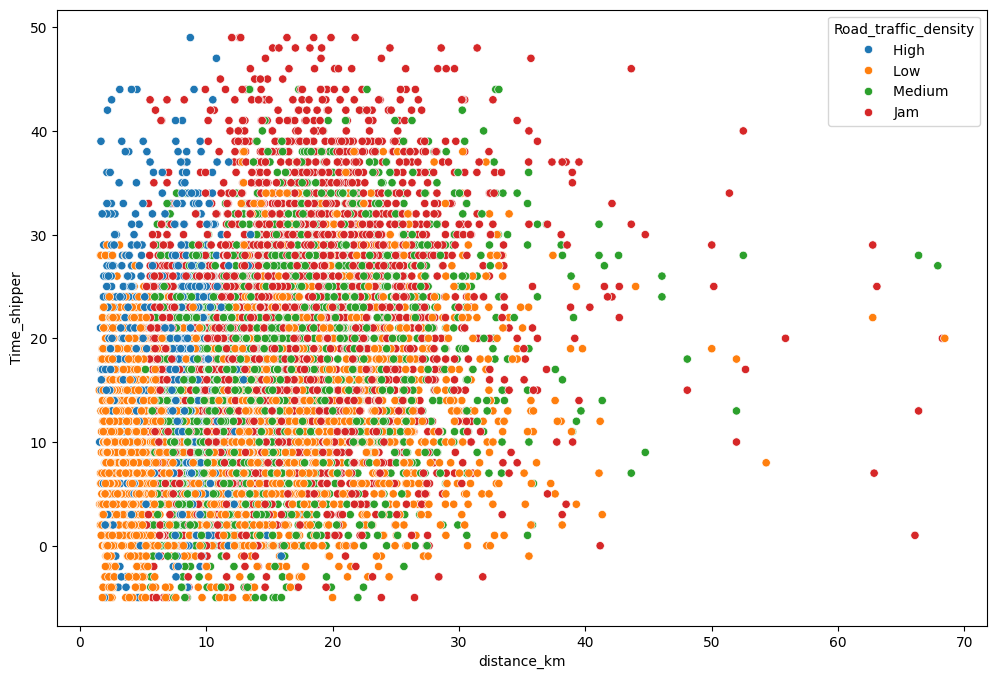

In [48]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_new, x="distance_km", y="Time_shipper", hue="Road_traffic_density")


In [49]:
filtered_df = df_new[df_new['Time_shipper'] <= 0]
count_values = len(filtered_df)

print(f"Số lượng giá trị <=0: {count_values}")
print("Dòng có Time_shipper <= 0:")
print(filtered_df.to_string(index=False))


Số lượng giá trị <=0: 419
Dòng có Time_shipper <= 0:
 Delivery_person_Age  Delivery_person_Ratings  Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  Delivery_location_longitude Weather_conditions Road_traffic_density  Vehicle_condition Type_of_order   Type_of_vehicle  multiple_deliveries Festival           City  distance_km  day  month  quarter  year  day_of_week  is_month_start  is_month_end  is_quarter_start  is_quarter_end  is_year_start  is_year_end  is_weekend Time_Order_picked_formatted  order_prepare_time  Time_shipper  Hour_Picked
                21.0                      4.7            22.552672             88.352885                   22.582672                    88.382885              Windy                 Jam                   0         Meal        motorcycle                   1.0      No          Urban        6.4805   15      2        1  2022            1               0             0                 0               0              0            0       

In [50]:
mean_order_prepare_time = df_new['order_prepare_time'].mean()
median_order_prepare_time = df_new['order_prepare_time'].median()
mode_order_prepare_time = df_new['order_prepare_time'].mode().iloc[0] 

print(f"Trung bình của order_prepare_time: {mean_order_prepare_time}")
print(f"Trung vị của order_prepare_time: {median_order_prepare_time}")
print(f"Mode của order_prepare_time: {mode_order_prepare_time}")


Trung bình của order_prepare_time: 9.917014560635373
Trung vị của order_prepare_time: 10.0
Mode của order_prepare_time: 5.0


In [51]:
mean_time_shipper = df_new['Time_shipper'].mean()
median_time_shipper = df_new['Time_shipper'].median()
mode_time_shipper = df_new['Time_shipper'].mode().iloc[0]  

print(f"Trung bình của Time_shipper: {mean_time_shipper}")
print(f"Trung vị của Time_shipper: {median_time_shipper}")
print(f"Mode của Time_shipper: {mode_time_shipper}")


Trung bình của Time_shipper: 16.640667956419918
Trung vị của Time_shipper: 16.0
Mode của Time_shipper: 11.0


In [52]:
# # Lọc ra các dòng có Time_shipper <= 0 và thay thế giá trị đó bằng giá trị từ cột Time_taken(min)
# df_new.loc[df_new['Time_shipper'] <= 0, 'Time_shipper'] = df_new.loc[df_new['Time_shipper'] <= 0, 'Time_taken(min)']
# # Tính mode của cột order_prepare_time
# mode_order_prepare_time = df_new['order_prepare_time'].mode().iloc[0]

# # Thay thế các giá trị <=0 trong cột order_prepare_time bằng giá trị mode
# df_new.loc[df_new['order_prepare_time'] <= 0, 'order_prepare_time'] = mode_order_prepare_time


In [53]:
df_new['Time_shipper'] = df_new['Time_shipper'].apply(lambda x: 1.45 if x <= 0 else x)


In [54]:
# mask = (df_new['distance_km'] > 60) & (df_new['Time_shipper'] < 5)
# df_new.loc[mask, 'distance_km'] = 8

<Axes: xlabel='distance_km', ylabel='Time_shipper'>

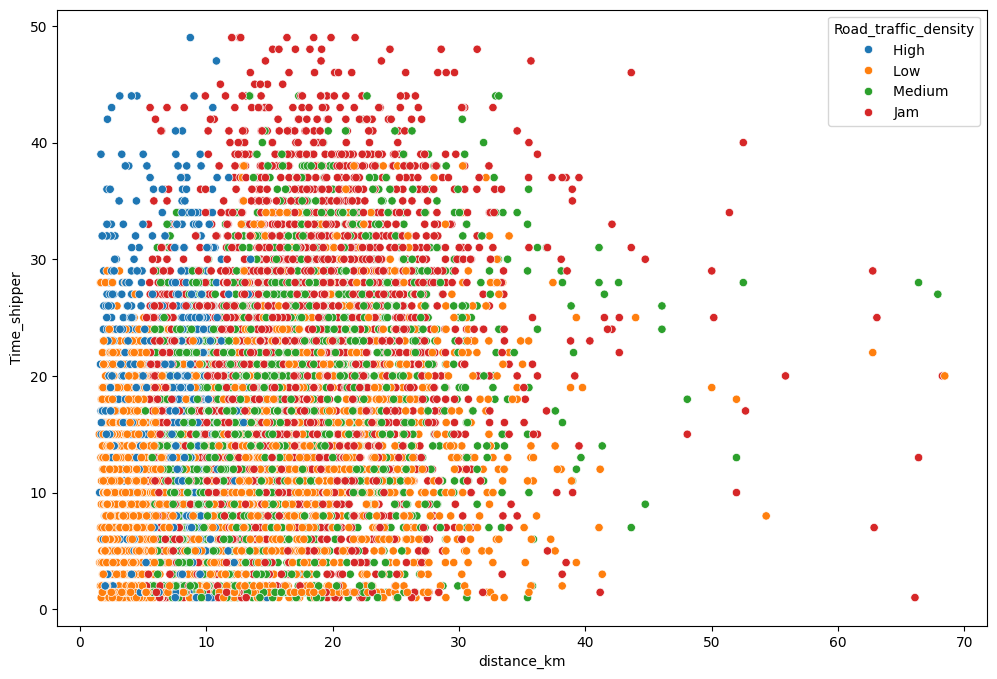

In [55]:
plt.figure(figsize=(12, 8))

sns.scatterplot(data=df_new, x="distance_km", y="Time_shipper", hue="Road_traffic_density")
#sns.lineplot(data=df_new, x="distance_km", y="Time_shipper", hue="Road_traffic_density", ci=None)


### Biểu đồ phân tán giữa tuổi và thời gian giao hàng

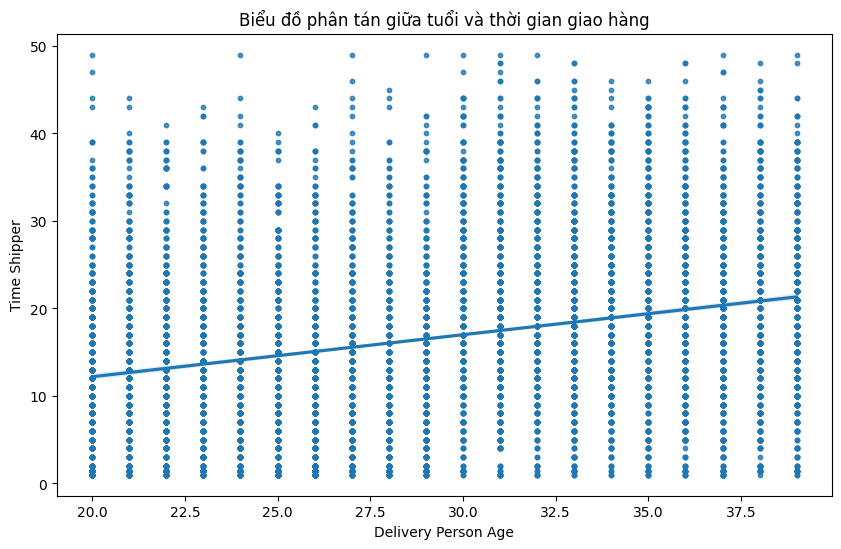

In [56]:
plt.figure(figsize=(10, 6))
sns.regplot(x=df_new['Delivery_person_Age'], y=df_new['Time_shipper'], scatter_kws={"s": 10})
plt.title('Biểu đồ phân tán giữa tuổi và thời gian giao hàng')
plt.xlabel('Delivery Person Age')
plt.ylabel('Time Shipper')
plt.show()


### Biểu đồ phân tán multiple_deliveries và Time Shipper

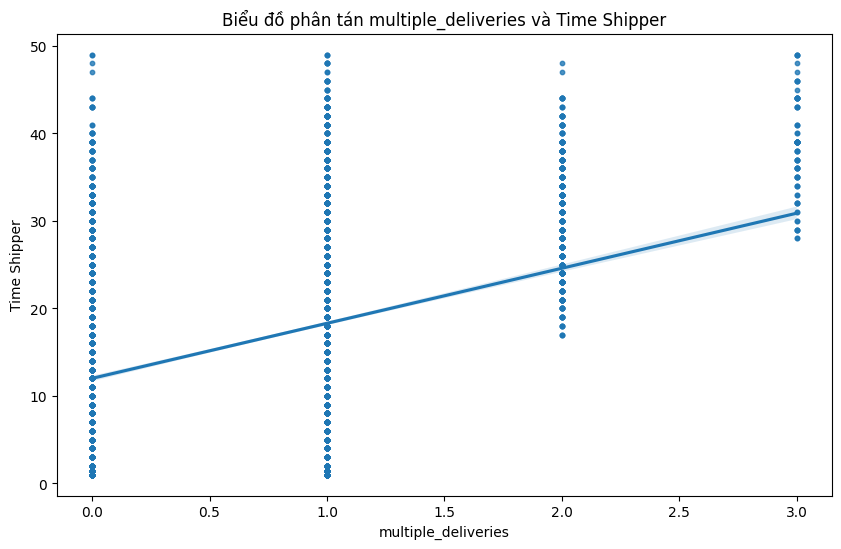

In [57]:
plt.figure(figsize=(10, 6))
sns.regplot(x=df_new['multiple_deliveries'], y=df_new['Time_shipper'], scatter_kws={"s": 10})
plt.title('Biểu đồ phân tán multiple_deliveries và Time Shipper')
plt.xlabel('multiple_deliveries')
plt.ylabel('Time Shipper')
plt.show()


In [58]:
def drop_columns(df):
    df.drop(['Hour_Picked', 'Time_Order_picked_formatted'],axis=1,inplace=True)
    
drop_columns(df_new)


In [59]:
# Chuyển đổi các cột thành chuỗi và xóa dấu cách thừa
columns_to_process = ['Road_traffic_density', 'City', 'Type_of_vehicle', 'Type_of_order', 'Festival']

df_new[columns_to_process] = df_new[columns_to_process].apply(lambda x: x.astype(str).str.strip())


In [60]:
df_new.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,distance_km,day,month,quarter,year,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend,order_prepare_time,Time_shipper
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,5.1959,19,3,1,2022,5,0,0,0,0,0,0,1,15.0,9.0
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,Sandstorms,Low,0,Drinks,motorcycle,1.0,No,Urban,5.1475,19,3,1,2022,5,0,0,0,0,0,0,1,15.0,11.0
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,Sunny,Medium,0,Buffet,motorcycle,1.0,No,Metropolitian,13.1790,4,5,2,2022,2,0,0,0,0,0,0,0,10.0,11.0
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,Cloudy,High,1,Snack,scooter,1.0,No,Metropolitian,10.5799,26,3,1,2022,5,0,0,0,0,0,0,1,15.0,15.0
5,22.0,4.8,17.431668,78.408321,17.461668,78.438321,Cloudy,Jam,0,Buffet,motorcycle,1.0,No,Urban,10.0741,3,11,4,2022,3,0,0,0,0,0,0,0,10.0,16.0


## Mã hóa DL

### Road_traffic_density, Weather_conditions, Road_traffic_density, Festival - Ordinal

In [61]:
from sklearn.preprocessing import OrdinalEncoder

# Xóa dấu cách sau mỗi danh mục trong danh sách
categories = [['Low', 'Medium', 'Jam', 'High']]

# Khởi tạo và fit OrdinalEncoder
oe = OrdinalEncoder(categories=categories)
encoded_labels = oe.fit_transform(df_new[['Road_traffic_density']])

# Ghi đè trực tiếp cột Road_traffic_density trong DataFrame df_new
df_new['Road_traffic_density'] = encoded_labels.flatten()
df_new['Road_traffic_density'] = df_new['Road_traffic_density'].astype(int)

df_new.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,distance_km,day,month,quarter,year,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend,order_prepare_time,Time_shipper
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,Sunny,3,2,Snack,motorcycle,0.0,No,Urban,5.1959,19,3,1,2022,5,0,0,0,0,0,0,1,15.0,9.0
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,Sandstorms,0,0,Drinks,motorcycle,1.0,No,Urban,5.1475,19,3,1,2022,5,0,0,0,0,0,0,1,15.0,11.0
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,Sunny,1,0,Buffet,motorcycle,1.0,No,Metropolitian,13.1790,4,5,2,2022,2,0,0,0,0,0,0,0,10.0,11.0
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,Cloudy,3,1,Snack,scooter,1.0,No,Metropolitian,10.5799,26,3,1,2022,5,0,0,0,0,0,0,1,15.0,15.0
5,22.0,4.8,17.431668,78.408321,17.461668,78.438321,Cloudy,2,0,Buffet,motorcycle,1.0,No,Urban,10.0741,3,11,4,2022,3,0,0,0,0,0,0,0,10.0,16.0


In [62]:

categories = [['Sunny', 'Cloudy', 'Stormy', 'Fog', 'Windy', 'Sandstorms']]

oe = OrdinalEncoder(categories=categories)
encoded_labels = oe.fit_transform(df_new[['Weather_conditions']])

df_new['Weather_conditions'] = encoded_labels.flatten()
df_new['Weather_conditions'] = df_new['Weather_conditions'].astype(int)

df_new.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,distance_km,day,month,quarter,year,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend,order_prepare_time,Time_shipper
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,0,3,2,Snack,motorcycle,0.0,No,Urban,5.1959,19,3,1,2022,5,0,0,0,0,0,0,1,15.0,9.0
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,5,0,0,Drinks,motorcycle,1.0,No,Urban,5.1475,19,3,1,2022,5,0,0,0,0,0,0,1,15.0,11.0
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,0,1,0,Buffet,motorcycle,1.0,No,Metropolitian,13.1790,4,5,2,2022,2,0,0,0,0,0,0,0,10.0,11.0
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,1,3,1,Snack,scooter,1.0,No,Metropolitian,10.5799,26,3,1,2022,5,0,0,0,0,0,0,1,15.0,15.0
5,22.0,4.8,17.431668,78.408321,17.461668,78.438321,1,2,0,Buffet,motorcycle,1.0,No,Urban,10.0741,3,11,4,2022,3,0,0,0,0,0,0,0,10.0,16.0


In [63]:
categories = [['Metropolitian', 'Urban', 'Semi-Urban', ]]

oe = OrdinalEncoder(categories=categories)
encoded_labels = oe.fit_transform(df_new[['City']])

# Ghi đè trực tiếp cột Road_traffic_density trong DataFrame df_new
df_new['City'] = encoded_labels.flatten()
df_new['City'] = df_new['City'].astype(int)

df_new.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,distance_km,day,month,quarter,year,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend,order_prepare_time,Time_shipper
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,0,3,2,Snack,motorcycle,0.0,No,1,5.1959,19,3,1,2022,5,0,0,0,0,0,0,1,15.0,9.0
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,5,0,0,Drinks,motorcycle,1.0,No,1,5.1475,19,3,1,2022,5,0,0,0,0,0,0,1,15.0,11.0
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,0,1,0,Buffet,motorcycle,1.0,No,0,13.1790,4,5,2,2022,2,0,0,0,0,0,0,0,10.0,11.0
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,1,3,1,Snack,scooter,1.0,No,0,10.5799,26,3,1,2022,5,0,0,0,0,0,0,1,15.0,15.0
5,22.0,4.8,17.431668,78.408321,17.461668,78.438321,1,2,0,Buffet,motorcycle,1.0,No,1,10.0741,3,11,4,2022,3,0,0,0,0,0,0,0,10.0,16.0


In [64]:
categories = [['No', 'Yes']]

oe = OrdinalEncoder(categories=categories)
encoded_labels = oe.fit_transform(df_new[['Festival']])

# Ghi đè trực tiếp cột Road_traffic_density trong DataFrame df_new
df_new['Festival'] = encoded_labels.flatten()
df_new['Festival'] = df_new['Festival'].astype(int)

df_new.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,distance_km,day,month,quarter,year,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend,order_prepare_time,Time_shipper
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,0,3,2,Snack,motorcycle,0.0,0,1,5.1959,19,3,1,2022,5,0,0,0,0,0,0,1,15.0,9.0
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,5,0,0,Drinks,motorcycle,1.0,0,1,5.1475,19,3,1,2022,5,0,0,0,0,0,0,1,15.0,11.0
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,0,1,0,Buffet,motorcycle,1.0,0,0,13.1790,4,5,2,2022,2,0,0,0,0,0,0,0,10.0,11.0
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,1,3,1,Snack,scooter,1.0,0,0,10.5799,26,3,1,2022,5,0,0,0,0,0,0,1,15.0,15.0
5,22.0,4.8,17.431668,78.408321,17.461668,78.438321,1,2,0,Buffet,motorcycle,1.0,0,1,10.0741,3,11,4,2022,3,0,0,0,0,0,0,0,10.0,16.0


In [65]:
# Kiểm tra tên của tất cả các cột trong DataFrame
print(df_new.columns)


Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Weather_conditions',
       'Road_traffic_density', 'Vehicle_condition', 'Type_of_order',
       'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City',
       'distance_km', 'day', 'month', 'quarter', 'year', 'day_of_week',
       'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end',
       'is_year_start', 'is_year_end', 'is_weekend', 'order_prepare_time',
       'Time_shipper'],
      dtype='object')


### Type_of_vehicle, Type_of_order - One hot

In [66]:
df_encoded = pd.get_dummies(df_new, columns=['Type_of_vehicle'])
df_new = df_encoded 

df_new.replace({True: 1, False: 0}, inplace=True)
df_new.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,multiple_deliveries,Festival,City,distance_km,day,month,quarter,year,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend,order_prepare_time,Time_shipper,Type_of_vehicle_electric_scooter,Type_of_vehicle_motorcycle,Type_of_vehicle_scooter
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,0,3,2,Snack,0.0,0,1,5.1959,19,3,1,2022,5,0,0,0,0,0,0,1,15.0,9.0,0,1,0
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,5,0,0,Drinks,1.0,0,1,5.1475,19,3,1,2022,5,0,0,0,0,0,0,1,15.0,11.0,0,1,0
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,0,1,0,Buffet,1.0,0,0,13.1790,4,5,2,2022,2,0,0,0,0,0,0,0,10.0,11.0,0,1,0
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,1,3,1,Snack,1.0,0,0,10.5799,26,3,1,2022,5,0,0,0,0,0,0,1,15.0,15.0,0,0,1
5,22.0,4.8,17.431668,78.408321,17.461668,78.438321,1,2,0,Buffet,1.0,0,1,10.0741,3,11,4,2022,3,0,0,0,0,0,0,0,10.0,16.0,0,1,0


In [67]:
df_encoded = pd.get_dummies(df_new, columns=['Type_of_order'])
df_new = df_encoded 

df_new.replace({True: 1, False: 0}, inplace=True)
df_new.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Weather_conditions,Road_traffic_density,Vehicle_condition,multiple_deliveries,Festival,City,distance_km,day,month,quarter,year,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend,order_prepare_time,Time_shipper,Type_of_vehicle_electric_scooter,Type_of_vehicle_motorcycle,Type_of_vehicle_scooter,Type_of_order_Buffet,Type_of_order_Drinks,Type_of_order_Meal,Type_of_order_Snack
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,0,3,2,0.0,0,1,5.1959,19,3,1,2022,5,0,0,0,0,0,0,1,15.0,9.0,0,1,0,0,0,0,1
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,5,0,0,1.0,0,1,5.1475,19,3,1,2022,5,0,0,0,0,0,0,1,15.0,11.0,0,1,0,0,1,0,0
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,0,1,0,1.0,0,0,13.1790,4,5,2,2022,2,0,0,0,0,0,0,0,10.0,11.0,0,1,0,1,0,0,0
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,1,3,1,1.0,0,0,10.5799,26,3,1,2022,5,0,0,0,0,0,0,1,15.0,15.0,0,0,1,0,0,0,1
5,22.0,4.8,17.431668,78.408321,17.461668,78.438321,1,2,0,1.0,0,1,10.0741,3,11,4,2022,3,0,0,0,0,0,0,0,10.0,16.0,0,1,0,1,0,0,0


### Mô hình

In [68]:
X = df_new.drop(['Time_shipper'], axis=1) 
y = df_new['Time_shipper']  
feature_names = X.columns.tolist()
print(feature_names)


['Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude', 'Weather_conditions', 'Road_traffic_density', 'Vehicle_condition', 'multiple_deliveries', 'Festival', 'City', 'distance_km', 'day', 'month', 'quarter', 'year', 'day_of_week', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end', 'is_weekend', 'order_prepare_time', 'Type_of_vehicle_electric_scooter', 'Type_of_vehicle_motorcycle', 'Type_of_vehicle_scooter', 'Type_of_order_Buffet', 'Type_of_order_Drinks', 'Type_of_order_Meal', 'Type_of_order_Snack']


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7856, 33)
(7856,)
(1965, 33)
(1965,)


In [70]:
# Kiểm tra các cột không phải là số
non_numeric_columns = X.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_columns)


Non-numeric columns: Index([], dtype='object')


## Scaler

In [71]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

columns_to_scale = ['Delivery_person_Age', 'Delivery_person_Ratings', 'multiple_deliveries', 'distance_km', 'order_prepare_time']
scaler.fit(df_new[columns_to_scale])

df_new[columns_to_scale] = scaler.transform(df_new[columns_to_scale])

In [72]:
df_new.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Weather_conditions,Road_traffic_density,Vehicle_condition,multiple_deliveries,Festival,City,distance_km,day,month,quarter,year,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend,order_prepare_time,Time_shipper,Type_of_vehicle_electric_scooter,Type_of_vehicle_motorcycle,Type_of_vehicle_scooter,Type_of_order_Buffet,Type_of_order_Drinks,Type_of_order_Meal,Type_of_order_Snack
0,0.894737,1.000000,22.745049,75.892471,22.765049,75.912471,0,3,2,0.000000,0,1,0.054617,19,3,1,2022,5,0,0,0,0,0,0,1,1.0,9.0,0,1,0,0,0,0,1
2,0.157895,0.411765,12.914264,77.678400,12.924264,77.688400,5,0,0,0.333333,0,1,0.053894,19,3,1,2022,5,0,0,0,0,0,0,1,1.0,11.0,0,1,0,0,1,0,0
3,0.947368,0.764706,11.003669,76.976494,11.053669,77.026494,0,1,0,0.333333,0,0,0.173912,4,5,2,2022,2,0,0,0,0,0,0,0,0.5,11.0,0,1,0,1,0,0,0
4,0.631579,0.647059,12.972793,80.249982,13.012793,80.289982,1,3,1,0.333333,0,0,0.135072,26,3,1,2022,5,0,0,0,0,0,0,1,1.0,15.0,0,0,1,0,0,0,1
5,0.105263,0.882353,17.431668,78.408321,17.461668,78.438321,1,2,0,0.333333,0,1,0.127514,3,11,4,2022,3,0,0,0,0,0,0,0,0.5,16.0,0,1,0,1,0,0,0


In [73]:
print(df_new.dtypes)

Delivery_person_Age                 float64
Delivery_person_Ratings             float64
Restaurant_latitude                 float64
Restaurant_longitude                float64
Delivery_location_latitude          float64
Delivery_location_longitude         float64
Weather_conditions                    int32
Road_traffic_density                  int32
Vehicle_condition                     int64
multiple_deliveries                 float64
Festival                              int32
City                                  int32
distance_km                         float64
day                                   int32
month                                 int32
quarter                               int32
year                                  int32
day_of_week                           int32
is_month_start                        int32
is_month_end                          int32
is_quarter_start                      int32
is_quarter_end                        int32
is_year_start                   

## Tìm mô hình tốt nhất

In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

#  DecisionTreeRegressor
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)

# RandomForestRegressor
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

#  Gradient Boosting Regression
gd_model = GradientBoostingRegressor()
gd_model.fit(X_train, y_train)
gd_predictions = gd_model.predict(X_test)

#  XGBoostRegressor
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

# Tính toán các chỉ số đánh giá
def print_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Metrics:")
    print(f"MAE: {mae:.3f}")
    # print(f"MSE: {mse}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²: {r2:.3f}")
    # print("\n")

print_metrics(y_test, lr_predictions, "Linear Regression")
print_metrics(y_test, dt_predictions, "Decision Tree Regressor")
print_metrics(y_test, rf_predictions, "Random Forest Regressor")
print_metrics(y_test, gd_predictions, "Gradient Boosting Regressor")
print_metrics(y_test, xgb_predictions, "XGBoost Regressor")

Linear Regression Metrics:
MAE: 4.964
RMSE: 6.231
R²: 0.625
Decision Tree Regressor Metrics:
MAE: 4.612
RMSE: 6.374
R²: 0.608
Random Forest Regressor Metrics:
MAE: 3.585
RMSE: 4.607
R²: 0.795
Gradient Boosting Regressor Metrics:
MAE: 3.717
RMSE: 4.687
R²: 0.788
XGBoost Regressor Metrics:
MAE: 3.510
RMSE: 4.455
R²: 0.808


In [75]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

model = xgb.XGBRegressor()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [5, 7, 9],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
#     'gamma': [0, 0.1, 0.2],
#     'min_child_weight': [1, 3, 5],
#     'alpha': [0, 0.1, 1],
#     'lambda': [1, 1.5, 2]
# }


grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("XGBRegressor:")
print("Best parameters:", grid_search.best_params_)
print("Best R2 score:", grid_search.best_score_)


### modal

In [76]:

model = xgb.XGBRegressor(colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0)

model.fit(X_train, y_train,
         eval_set = [(X_train, y_train), (X_test, y_test)], verbose = True)
#model.save_model('xgb_model.h5')
model.save_model('xgb_model.json')


[0]	validation_0-rmse:9.35010	validation_1-rmse:9.50903
[1]	validation_0-rmse:8.75492	validation_1-rmse:8.91182
[2]	validation_0-rmse:8.24622	validation_1-rmse:8.42036
[3]	validation_0-rmse:7.80629	validation_1-rmse:7.99880
[4]	validation_0-rmse:7.43054	validation_1-rmse:7.61863
[5]	validation_0-rmse:7.11484	validation_1-rmse:7.33522
[6]	validation_0-rmse:6.80550	validation_1-rmse:7.04750
[7]	validation_0-rmse:6.46846	validation_1-rmse:6.71931
[8]	validation_0-rmse:6.25061	validation_1-rmse:6.51685
[9]	validation_0-rmse:6.01339	validation_1-rmse:6.28462
[10]	validation_0-rmse:5.78422	validation_1-rmse:6.06284
[11]	validation_0-rmse:5.59388	validation_1-rmse:5.87722
[12]	validation_0-rmse:5.43874	validation_1-rmse:5.73072
[13]	validation_0-rmse:5.26662	validation_1-rmse:5.57784
[14]	validation_0-rmse:5.15223	validation_1-rmse:5.47817
[15]	validation_0-rmse:5.02585	validation_1-rmse:5.36096
[16]	validation_0-rmse:4.90761	validation_1-rmse:5.25259
[17]	validation_0-rmse:4.81454	validation

### Đánh giá độ đo XGB

In [77]:
y_pred = model.predict(X_test)
y_pred

mae_xgb = mean_absolute_error(y_test, y_pred)
mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", round(mae_xgb,2))
print("Mean Squared Error (MSE):", round(mse_xgb,2))
print("Root Mean Squared Error (RMSE):", round(rmse_xgb,2))
print("R-squared (R2) Score:", round(r2_xgb,2))

Mean Absolute Error (MAE): 3.36
Mean Squared Error (MSE): 18.0
Root Mean Squared Error (RMSE): 4.24
R-squared (R2) Score: 0.83


### So sánh giá trị dự đoán-thực tế

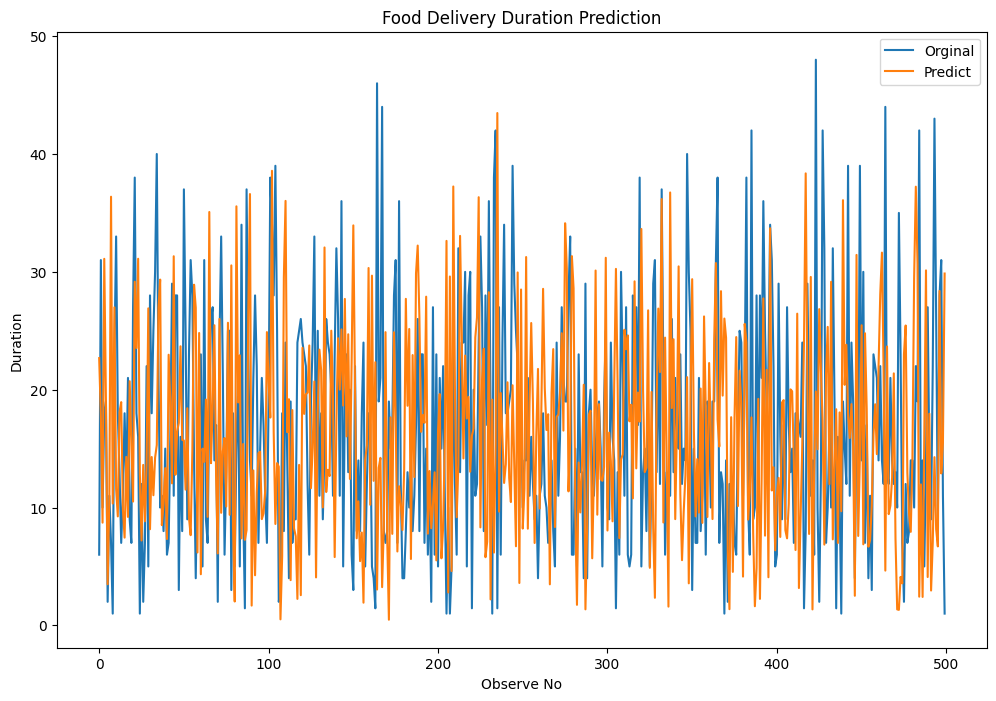

In [78]:
plt.figure(figsize=(12,8))
plt.plot(range(len(y_train[:500])),y_train[:500],label="Orginal")
plt.plot(range(len(y_train[:500])),y_pred[:500],label="Predict")
plt.title("Food Delivery Duration Prediction")
plt.ylabel("Duration")
plt.xlabel("Observe No")
plt.legend()
plt.show()

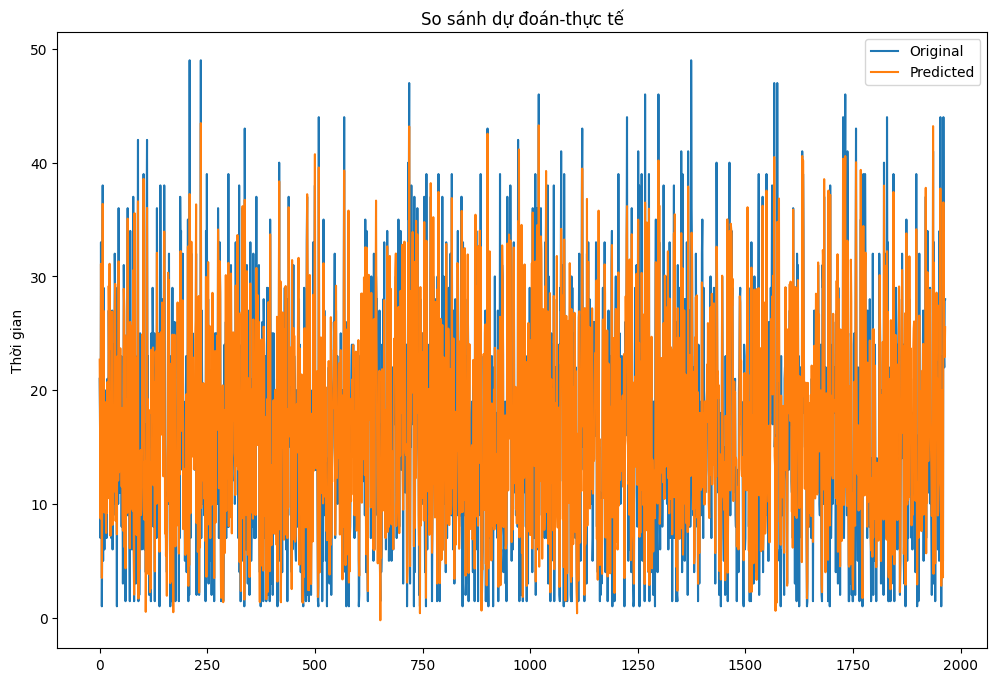

In [79]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

plt.figure(figsize=(12, 8))
plt.plot(range(len(y_test)), y_test, label="Original")
plt.plot(range(len(y_pred)), y_pred, label="Predicted")
plt.title("So sánh dự đoán-thực tế")
plt.ylabel("Thời gian")
plt.xlabel("")
plt.legend()
plt.show()


### So sánh gtri dự đoán và thực tế

In [80]:
comparison_df = pd.DataFrame({'Test': y_test, 'Predict': y_pred})
print(comparison_df)


       Test    Predict
7836   21.0  22.680626
4271   16.0  17.697987
740     7.0   8.717798
10820  33.0  31.105145
402    15.0  18.817604
...     ...        ...
518    44.0  36.510612
9739   24.0  28.090284
3760   22.0  24.735039
1200   28.0  22.902483
797    28.0  25.537676

[1965 rows x 2 columns]


### Thử với 2 bộ DL cùng khoảng cách nhưng khác biệt về đánh giá, thời tiết, giao thông...

In [81]:
# DL với điều kiện tốt
df_test = pd.read_csv("data/ktra1dong.csv")
def predict_delivery_time(data, model_path='xgb_model.json'):
    model = xgb.XGBRegressor()
    model.load_model(model_path)
    
    X = data.drop(['Time_shipper'], axis=1)  # Các đặc trưng
    y_pred = model.predict(X)
    
    return y_pred

# Dự đoán với dữ liệu mới
y_pred_new = predict_delivery_time(df_test)
print(y_pred_new)


[22.680626]


In [82]:
# DL với điều kiện xấu
df_test = pd.read_csv("data/KT16_06.csv")
def predict_delivery_time(data, model_path='xgb_model.json'):
    model = xgb.XGBRegressor()
    model.load_model(model_path)
    
    X = data.drop(['Time_shipper'], axis=1)  # Các đặc trưng
    y_pred = model.predict(X)
    
    return y_pred

# Dự đoán với dữ liệu mới
y_pred_new = predict_delivery_time(df_test)
print(y_pred_new)

[29.845951]


- Kết quả trả về cho thấy với điều kiện xấu, thời gian giao hàng sẽ lâu hơn

### Thử với DL có quãng đg ngắn hơn

In [83]:

df_test = pd.read_csv("data/18_06test_1dong.csv")
def predict_delivery_time(data, model_path='xgb_model.json'):
    model = xgb.XGBRegressor()
    model.load_model(model_path)
    
    X = data.drop(['Time_shipper'], axis=1)  # Các đặc trưng
    y_pred = model.predict(X)
    
    return y_pred

# Dự đoán với dữ liệu mới
y_pred_new = predict_delivery_time(df_test)
print(y_pred_new)


[7.2060833]


In [84]:

df_test = pd.read_csv("data/18_06_test1dong2.csv")
def predict_delivery_time(data, model_path='xgb_model.json'):
    model = xgb.XGBRegressor()
    model.load_model(model_path)
    
    X = data.drop(['Time_shipper'], axis=1)  # Các đặc trưng
    y_pred = model.predict(X)
    
    return y_pred

# Dự đoán với dữ liệu mới
y_pred_new = predict_delivery_time(df_test)
print(y_pred_new)


[12.500096]
